In [357]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

фиксы от ерове:
* добавил в point_set информацию о границе на х-координаты точек
* lr - кастомный
* теперь везде степ декей
* макс число эпох уменьшил поэтому
* количество точек увеличил примерно в 5 раз чтобы порядка 100-150 их было
* в Нестерове эксперементально выянилось что какой-то ужас происходит.
    Там лучше очень маленькие параметры брать чтобы ЛР=0.005 сходился почти всегда, а для бОльшего ЛР еще меньше, что странно на самом деле, мы же на этот коэфф умножаем старый градиент, то есть получается что почти не используем тут его :(
* в Адаме на лекции говорили что круто брать 0.9 и 0.999 коэфициенты, но у нас второй чем меньше чем круче 

In [358]:
DEFAULT_LR = 0.005

In [359]:
# linear function, computes k-th coordinate by k-1 first
#   coefficients - k-1-dim array
#   x - k-1-dim array
def f(coefficients, x, coefficient_bound = 0):
    return np.sum(coefficients * x) + coefficient_bound * (2 * np.random.random_sample() - 1)

# scale coord array into [0; 1] interval
def scale_dim(coords):
    mn = coords[0]
    mx = coords[0]
    for i in range(0, len(coords)):
        mn = min(mn, coords[i])
        mx = max(mx, coords[i])
    if mn == mx:
        for i in range(0, len(coords)):
            coords[i] = 0
    else:
        for i in range(0, len(coords)):
            coords[i] = (coords[i] - mn) / (mx - mn)
    return [coords, mn, mx]

# scale all point_set coords into [0; 1] interval
def apply_scaling(points):
    x = points.x.copy()
    y = points.y.copy()
    for k in range(0, points.dim - 1):
        coords = np.asarray([])
        for i in range(0, points.n):
            coords = np.append(coords, points.x[i][k])
        coords = scale_dim(coords)[0]
        for i in range(0, points.n):
            x[i][k] = coords[i]
    y = scale_dim(y)[0] 
    return point_set(points.n, points.dim, x, y, 1)

class point_set:
    # copy ctor :|
    def __init__(self, n, dim, x, y, coords_bound = 0):
        self.n = n
        self.dim = dim
        self.x = x
        self.y = y
        self.coords_bound = coords_bound

# create point_set:
# n - amount of points
# dim - space's dim
# coords_bound - upper bound on absolute first k-1 coordinates value
# coefficients_bound - upper bound on absolute coefficients value
def create_point_set(n, dim, coords_bound, coefficients_bound, coefficients = []):
    x = coords_bound * np.random.random_sample((n, dim - 1))
    if coefficients == []:
        coefficients = coefficients_bound * np.random.random_sample((dim - 1)) - coefficients_bound
    else:
        coefficients = np.asarray(coords_bound)

    y = np.asarray([])
    for i in range(0, n):
        y = np.append(y, f(coefficients, x[i], coefficients_bound))
    # y = coords_bound * np.random.random_sample((n))
    return point_set(n, dim, x, y, coords_bound)

# EPOCH_MAX = 1000
# input_2d = create_point_set(30, 2, 10., 2.)
# input_3d = create_point_set(30, 3, 10., 2.)
# input_small = create_point_set(25, 5, 20., 1.)
# input_large = create_point_set(30, 10, 30., 2.)
# input_wild = create_point_set(5, 6, 1000., 1.)
# input_custom = create_point_set(30, 2, 20, 0, [-5, 3])
EPOCH_MAX = 100
input_2d = create_point_set(150, 2, 20., 10.)
input_3d = create_point_set(150, 3, 20., 2.)
input_small = create_point_set(100, 10, 20., 1.)
input_large = create_point_set(150, 100, 1000., 2.)
# input_wild = create_point_set(100, 20, 1000., 1.)
# input_custom = create_point_set(150, 20, 20, 0, [-5, 3])

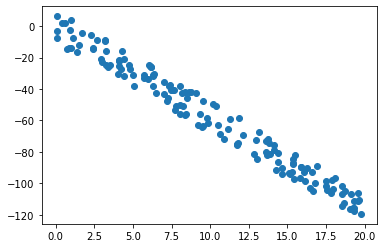

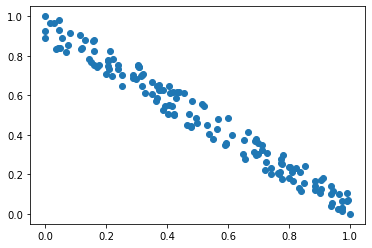

In [360]:
input_2d_scaled = input_2d
input_2d_scaled = apply_scaling(input_2d_scaled)

ax = plt.figure().add_subplot()
ax.plot(input_2d.x, input_2d.y, 'o')

ax = plt.figure().add_subplot()
ax.plot(input_2d_scaled.x, input_2d_scaled.y, 'o')

In [361]:
# considered loss function for points_set
# f = sum from i=0 to n-1 of (a*x_i + b - y_i)^2, where a.append(b) = c
#   points - point_set
#   c - k-dim array of coefficients points = [a_0, ..., a_k-2, b]
def loss_function(points, c):
    f = 0
    for i in range(0, points.n):
        f += (c[0 : points.dim - 1] @ points.x[i] + c[points.dim - 1] - points.y[i]) ** 2
    return f

In [362]:
# calculate gradient [d/da, d/db] of loss function for points_set by variables x_i, where i in ids
#   points - point_set
#   ids - array of indices for taking gradient
#   coeffs - current loss function = [a_0, ..., a_k-2, b]
def loss_function_grad(points, ids, coeffs):
    a = coeffs[0 : points.dim - 1]
    b = coeffs[points.dim - 1]
    grad_a = np.asarray([0.] * len(a))
    grad_b = 0.
    for i in ids:
        grad_a += 2 * (a @ points.x[i] + b - points.y[i]) * points.x[i]
        grad_b += 2 * (a @ points.x[i] + b - points.y[i])
    return np.append(grad_a, grad_b)

In [363]:
# stochastic gradient descent
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   gradinet_supplier - :)
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   _param - ignored
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, _param_1, _param_2):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = DEFAULT_LR
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index : to], coeffs)
        coeffs_step = coeffs - current_lr * grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

In [364]:
constant_lr = (lambda current_lr, epoch: DEFAULT_LR)
def step_decay(lr, epoch, epochs_drop = 2, drop = 0.5):
   return lr * pow(drop, floor((1 + epoch) / epochs_drop))
   
colors = ["blue", "red", "green", "orange", "purple", "yellow", "pink", "brown", "black", "magenta"]

# call sgd with each possible batch_size for point_set
#   lr - function (current_lr, epoch)
def batch_size_analyze(points, lr = constant_lr, gd = sgd, param_1 = 0, param_2 = 0):
    epoches = np.asarray([])
    for batch in range(1, points.n + 1):
        result = gd(points, batch, loss_function_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX, param_1, param_2)
        epoches = np.append(epoches, len(result[1]))
    return epoches

# print batch_size_analyze(points, lr)
def print_batch_size_analyze(points, lr = constant_lr, gd = sgd, name='minibatch SGD', params_1 = [0], params_2 = [0]):
    if params_1 == [0] and params_2 == [0]:
        epoches = batch_size_analyze(points, lr, gd = gd, param_1 = 0)
        plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches)
    if params_1 != [0] and params_2 == [0]:
        for i in range(0, len(params_1)):
            epoches = batch_size_analyze(points, lr, gd = gd, param_1 = params_1[i])
            plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches, color = colors[i % len(colors)], label = "parameter=" + str(params_1[i]))
        plt.legend()
    if params_1 != [0] and params_2 != [0]:
        for i in range(0, len(params_1)):
            for j in range (0, len(params_2)):
                epoches = batch_size_analyze(points, lr, gd = gd, param_1 = params_1[i], param_2 = params_2[j])
                plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches, color = colors[(i*len(params_2)+j) % len(colors)], label = str(params_1[i])+ " " + str(params_2[j])) 
            plt.legend()
    plt.xlabel("batch")
    plt.ylabel("epoches")
    plt.title(name + " for n=" + str(points.n) + ", dim=" + str(points.dim) + ", coords<=" + str(points.coords_bound))
    plt.show()

In [365]:
# draw loss func values by epoch for point_set & given batch
#   lr - function (current_lr, epoch)
def print_loss_function_epochs(points, batch, lr = constant_lr, gd = sgd, name = 'minibatch SGD', param = 0, p = 0):
    result = gd(points, batch, loss_function_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX, param, p)

    loss_func_values = np.asarray([])
    for coeffs in result[1]:
        loss_func_values = np.append(loss_func_values, [loss_function(points, coeffs)])
        
    plt.plot(loss_func_values)
    plt.xlabel("epoch")
    plt.ylabel("loss function value")
    plt.title("loss function by " + name + " for n=" + str(points.n) + ", dim=" + str(points.dim) + ", coords<=" + str(points.coords_bound))
    plt.show()

Собственно, сами запуски SGD, minibatch SGD, GD на различных наборах точек:

In [366]:
# print_batch_size_analyze(input_2d)
# print_batch_size_analyze(input_3d)
# print_batch_size_analyze(input_small)
# print_batch_size_analyze(input_large)
# print_batch_size_analyze(input_wild)
# print_batch_size_analyze(input_custom)

Микровывод: как можно видеть, mini-batch SGD для лин. регрессии без каких либо оптимизаций действительно сильно "скачет" в показаниях сходимости для ранзных величин batch и размерности пространства точек. В подавляющем большинстве случаев сойтись не получается даже за 5000 эпох :( что подтверждает неэффиктивность вычисления частичного градиента для случайного набора данных.

Однако также, можно заметить следующие моменты:
* редко бывают случие, когда бы не сошелся SGD, но сошлись minibatch SGD или GD
* для batch < dim, сходимость достигается (если и достигается) за меньшее число эпох, по сравнению с ГС из лабораторной 1

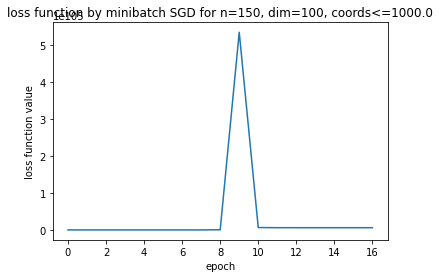

In [367]:
print_loss_function_epochs(input_large, 150, lr=step_decay)

Тем не менее в случаях, когда ГС (СГС) сходится, значения линейной регрессии действительно уменьшаются со временем, а значит, проблема расхождения за 5000 эпох действительно возникает из-за колеблющегося графика минимизирующей функции и констанного learning rate.

Похоже на ситуацию с функций Розенброка из первой лабораторной. Там мы решили эту проблему путем пересчета lr через ступенчатую функцию, и, как видно на графиках ниже, здесь она так же помогла. Следовательно расходимость minibatch SGD без модификаций для большинства расмотренных функций - оправдана

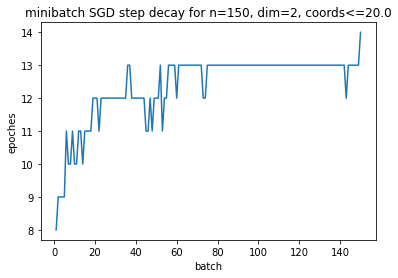

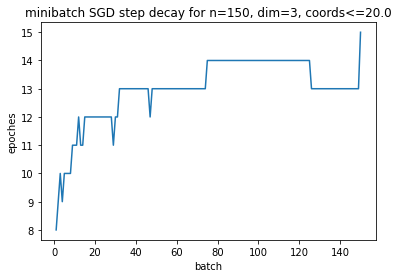

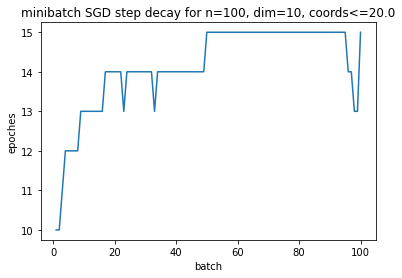

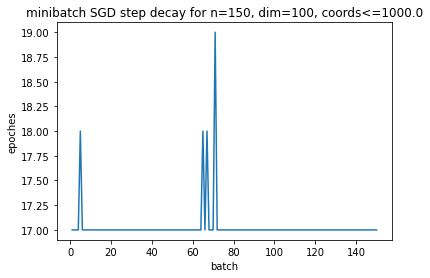

In [368]:
print_batch_size_analyze(input_2d, step_decay, name = "minibatch SGD step decay")
print_batch_size_analyze(input_3d, step_decay, name = "minibatch SGD step decay")
print_batch_size_analyze(input_small, step_decay, name = "minibatch SGD step decay")
print_batch_size_analyze(input_large, step_decay, name = "minibatch SGD step decay")
# print_batch_size_analyze(input_wild, step_decay, name = "minibatch SGD step decay")
# print_batch_size_analyze(input_custom, step_decay, name = "minibatch SGD step decay")

## Пункт 2. Исследовать влияние предварительной нормализации данных на сходимость

Рассмотрим scaling к диапазону [0, 1]

In [369]:
# check if all coords are scaled
def debug_check_scaling(points, l, r):
    ok = 1
    for i in range(0, points.n):    
        for k in range(0, points.dim - 1):
            ok = ok & (l <= points.x[i][k] <= r)
        ok = ok & (l <= points.y[i] <= r)
    return ok

# call sgd with each possible batch_size for point_set & scaled_point_set
# lr - function (current_lr, epoch)
def scaling_batch_size_compare(points, lr = constant_lr, name = "minibatch SGD"):
    epoches_points = batch_size_analyze(points, lr)
    plt.plot(np.linspace(1, len(epoches_points), len(epoches_points)), epoches_points, label='original point set', color='red')
    
    scaled_points = points
    scaled_points = apply_scaling(scaled_points)
    print("check scaling: " + str(debug_check_scaling(scaled_points, 0, 1)))
    epoches_points = batch_size_analyze(scaled_points, lr)
    plt.plot(np.linspace(1, len(epoches_points), len(epoches_points)), epoches_points, label='scaled [0; 1] point set', color='blue')
    
    
    plt.xlabel("batch")
    plt.ylabel("epoches")
    plt.title(name + " for n=" + str(points.n) + ", dim=" + str(points.dim) + ", coords<=" + str(points.coords_bound))
    plt.legend()
    plt.show()

In [370]:
# scaling_batch_size_compare(input_2d)
# scaling_batch_size_compare(input_3d)
# scaling_batch_size_compare(input_small)
# scaling_batch_size_compare(input_large)
# scaling_batch_size_compare(input_custom)
# scaling_batch_size_compare(input_wild)

Микровывод: поскольку набор точек для скаллинга всегда случайный, то нельзя сделать вывод, что скаллинг всегда выигрывает по скорости сходимости у стандартного minibatch SGD. Можно заметить, что чем плотнее изначально расположены точки, тем хуже в вопросе сходимости работает minibatch SGD со скаллингом. Так же ради интереса проверим со ступенчатой функцией: (там вообще летает)

check scaling: 1


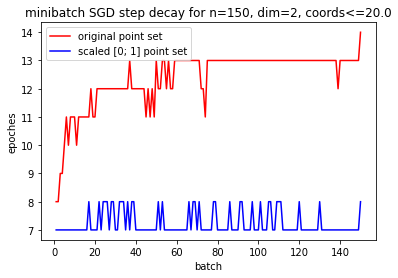

check scaling: 1


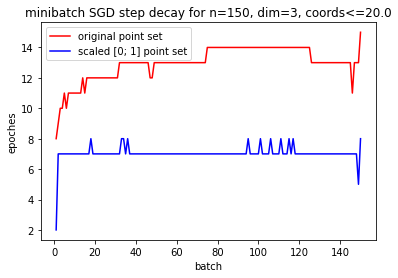

check scaling: 1


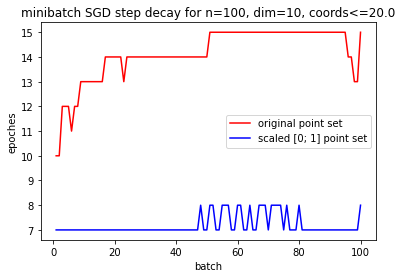

check scaling: 1


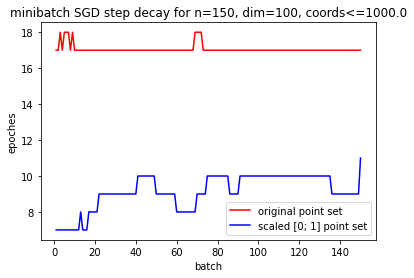

In [371]:
scaling_batch_size_compare(input_2d, step_decay, name = "minibatch SGD step decay")
scaling_batch_size_compare(input_3d, step_decay, name = "minibatch SGD step decay")
scaling_batch_size_compare(input_small, step_decay, name = "minibatch SGD step decay")
scaling_batch_size_compare(input_large, step_decay, name = "minibatch SGD step decay")
# scaling_batch_size_compare(input_custom, step_decay, name = "minibatch SGD step decay")
# scaling_batch_size_compare(input_wild, step_decay, name = "minibatch SGD step decay")

## Пункт 3

In [372]:
# stochastic gradient descent with momentum
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   gradinet_supplier - :)
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   betta - parameter
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd_with_momentum(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, betta, param_2):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = DEFAULT_LR
    grad = np.asarray([0] * points.dim)
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + current_lr * gradinet_supplier(points, order[batch_index:to], coeffs)
        coeffs_step = coeffs - grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

### SGD with momentum

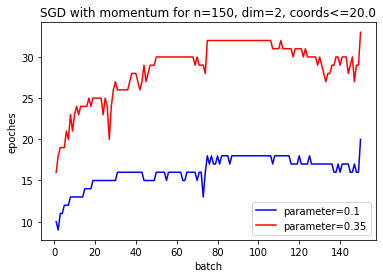

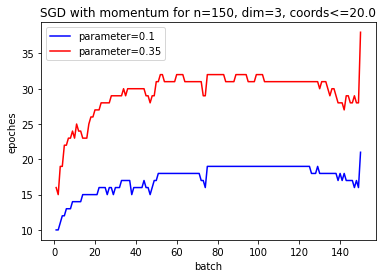

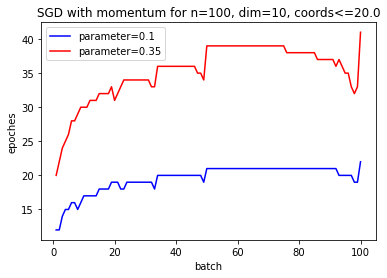

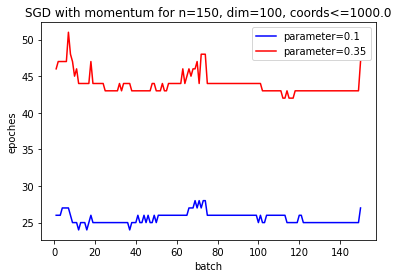

In [373]:
print_batch_size_analyze(input_2d, lr = step_decay, gd=sgd_with_momentum, name='SGD with momentum', params_1=[0.1, 0.35])
print_batch_size_analyze(input_3d, lr = step_decay, gd=sgd_with_momentum, name='SGD with momentum', params_1=[0.1, 0.35])
print_batch_size_analyze(input_small, lr = step_decay, gd=sgd_with_momentum, name='SGD with momentum', params_1=[0.1, 0.35])
print_batch_size_analyze(input_large, lr = step_decay, gd=sgd_with_momentum, name='SGD with momentum', params_1=[0.1, 0.35])
# print_batch_size_analyze(input_wild, lr = step_decay, gd=sgd_with_momentum, name='SGD with momentum', params_1=[0.1, 0.35])
# print_batch_size_analyze(input_custom, lr = step_decay, gd=sgd_with_momentum, name='SGD with momentum', params_1=[0.1, 0.35])

Микровывод: SGD with momentum помогает улучшить сходимость для некоторых фукнкций, однако требователен к подбору параметра и плодит много рантайм ворнингов из-за переполнения :(
### SGD with Nesterov momentum

In [374]:
# calculate gradient [d/da, d/db] of loss function for points_set by variables x_i, where i in ids
#   points - point_set
#   ids - array of indices for taking gradient
#   coeffs - current loss function = [a_0, ..., a_k-2, b]
#   betta - parameter
#   grad - previous step gradined
def nesterov_loss_function_grad(points, ids, coeffs, betta, grad):
    a = coeffs[0 : points.dim - 1]
    b = coeffs[points.dim - 1]
    grad_a = np.asarray([0.] * len(a))
    grad_b = 0.
    prev_grad_a = grad[0 : points.dim - 1]
    prev_grad_b = grad[points.dim - 1]
    for i in ids:
        grad_a += 2 * (a @ (points.x[i] - betta * prev_grad_a) + b - points.y[i] - betta * prev_grad_b) * (points.x[i] - betta * prev_grad_a)
        grad_b += 2 * (a @ (points.x[i] - betta * prev_grad_a) + b - points.y[i] - betta * prev_grad_b)
    return np.append(grad_a, grad_b)

# stochastic gradient descent with Nesterov momentum
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   _gradinet_supplier - ignored
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   betta - parameter
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd_with_nesterov_momentum(points, batch_size, _gradinet_supplier, starting_coeffs, lr, eps, epoches, betta, gamma):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = DEFAULT_LR
    grad = np.asarray([0] * points.dim)
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + current_lr * nesterov_loss_function_grad(points, order[batch_index:to], coeffs, betta, grad)
        coeffs_step = coeffs - grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

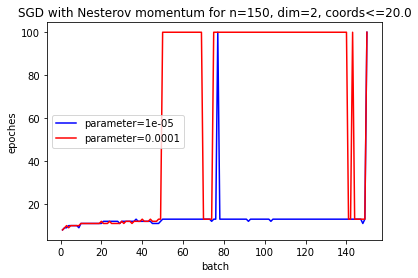

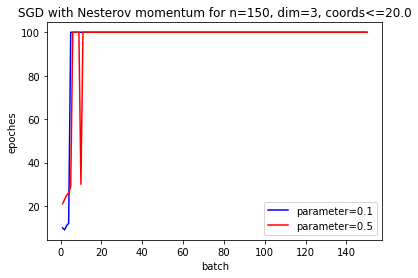

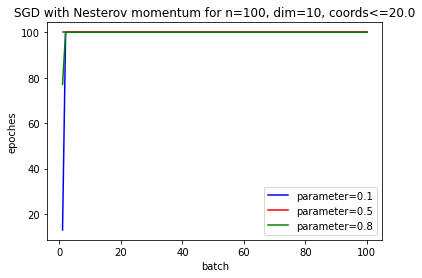

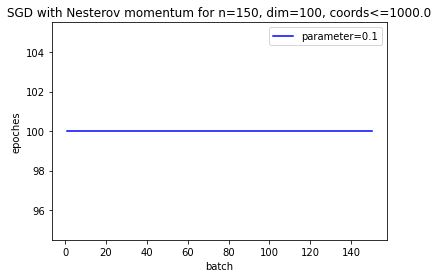

In [375]:
print_batch_size_analyze(input_2d, lr = step_decay, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params_1=[1e-5, 1e-4])
print_batch_size_analyze(input_3d, lr = step_decay, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params_1=[0.1, 0.5])
print_batch_size_analyze(input_small, lr = step_decay, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params_1=[0.1, 0.5, 0.8])
print_batch_size_analyze(input_large, lr = step_decay, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params_1=[0.1])
# print_batch_size_analyze(input_wild, lr = step_decay, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params_1=[1e-5, 1e-4])
# print_batch_size_analyze(input_custom, lr = step_decay, gd=sgd_with_nesterov_momentum, name='SGD with Nesterov momentum', params_1=[1e-5, 1e-4])

Микровывод: получили несколько изменный SGD with momentum, линии стали плавнее, что не очень понятно, хорошо или плохо. Функции, которые не сходили раньше, не сходятся и сейчас :( Запускал со ступенчатой функций и эти ГС, сходимость хотя бы при паре коэффициентов была у всех функций. Следовательно езе раз убеждаемся, что SGD, SGD with momentum и SGD with Nesterov momentum похоже друг на друга в плане производительности, и для сходимости требуется что-то более чуткое к лернинг рэйту и измерению

### ADA GRAD

по сути сглаживание не самого градиаента, а его квадрата бесконечно наклпленной суммы, ну жесть короче

In [376]:
def adagrad(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, betta, gamma):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = DEFAULT_LR
    grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        v = prev_v + np.power(grad, 2)
        coeffs_step = coeffs - np.divide(grad, np.power(v, 0.5))*current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        prev_v = v
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

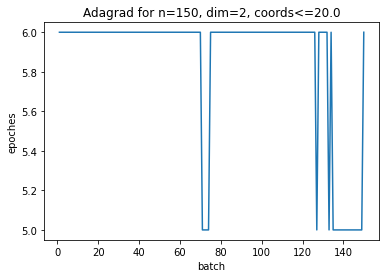

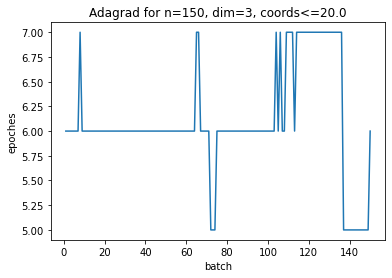

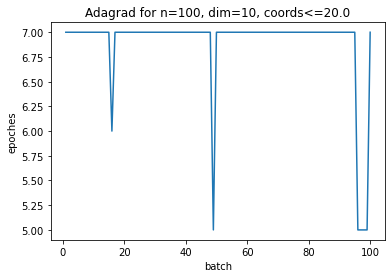

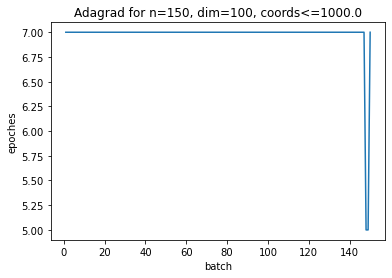

In [377]:
print_batch_size_analyze(input_2d, lr = step_decay, gd=adagrad, name='Adagrad')
print_batch_size_analyze(input_3d, lr = step_decay, gd=adagrad, name='Adagrad')
print_batch_size_analyze(input_small, lr = step_decay, gd=adagrad, name='Adagrad')
print_batch_size_analyze(input_large, lr = step_decay, gd=adagrad, name='Adagrad')
# print_batch_size_analyze(input_wild, lr = step_decay, gd=adagrad, name='Adagrad')
# print_batch_size_analyze(input_custom, lr = step_decay, gd=adagrad, name='Adagrad')

##### Как будто всё должно было начать приятнее сходиться, но произошел мем и оно такое же неприятное. Но всё же улучшения прослеживаются, например, последняя стала иногда сходиться

### RMS Prop

##### тут мы еще будем усреднять квадрат градиента, а потом уже сглаживаем, то есть появляется как и в моментуме параметр, жесть

In [378]:
def rms_prop(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, betta, gamma):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = DEFAULT_LR
    grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        v = prev_v*betta + (1-betta)*np.power(grad, 2)
        coeffs_step = coeffs - np.divide(grad, np.power(v, 0.5))*current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        prev_v = v
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

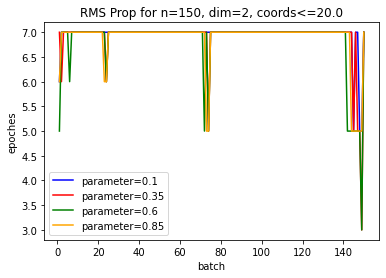

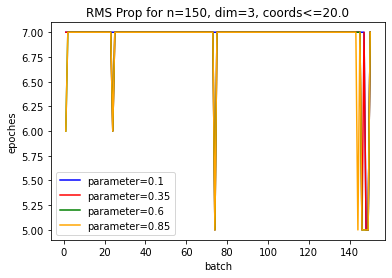

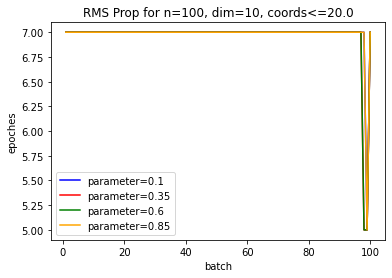

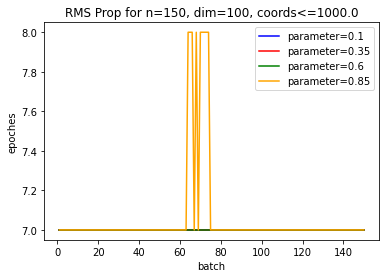

In [379]:
print_batch_size_analyze(input_2d, lr = step_decay, gd=rms_prop, name='RMS Prop', params_1=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_3d, lr = step_decay, gd=rms_prop, name='RMS Prop', params_1=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_small, lr = step_decay, gd=rms_prop, name='RMS Prop', params_1=[0.1, 0.35, 0.6, 0.85])
print_batch_size_analyze(input_large, lr = step_decay, gd=rms_prop, name='RMS Prop', params_1=[0.1, 0.35, 0.6, 0.85])
# print_batch_size_analyze(input_wild, lr = step_decay, gd=rms_prop, name='RMS Prop', params_1=[0.1, 0.35, 0.6, 0.85])
# print_batch_size_analyze(input_custom, lr = step_decay, gd=rms_prop, name='RMS Prop', params_1=[0.1, 0.35, 0.6, 0.85])

###### что-то не так видимо(

### ADAM

In [380]:
def adam(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches, betta, gamma):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    current_lr = DEFAULT_LR
    prev_grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    epsilon = np.asarray([0.1] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        
        #grad промежуточный градиент
        #grad_current тот, с которым работаем
        #prev_grad предыдущий
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        
        grad_current = betta * prev_grad + (1-betta) * grad
        v = prev_v*gamma + (1-gamma)*np.power(grad, 2)

        coeffs_step = coeffs - np.divide(grad_current, (np.power(v, 0.5) + epsilon))*current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        prev_v = v
        prev_grad = grad_current
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]


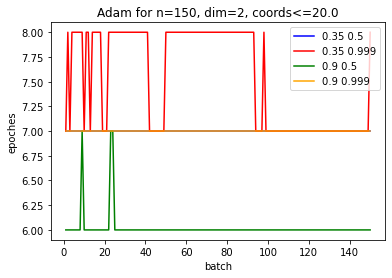

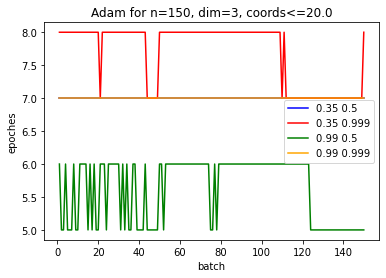

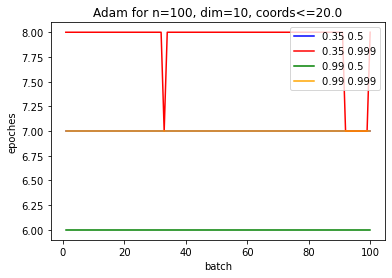

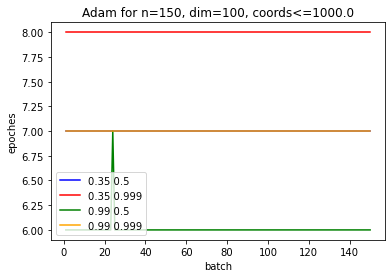

In [381]:
print_batch_size_analyze(input_2d, step_decay , gd=adam, name='Adam', params_1=[0.35, 0.9], params_2=[0.5, 0.999])
print_batch_size_analyze(input_3d, step_decay , gd=adam, name='Adam', params_1=[0.35, 0.99], params_2=[0.5, 0.999])
print_batch_size_analyze(input_small, step_decay , gd=adam, name='Adam', params_1=[0.35, 0.99], params_2=[0.5, 0.999])
print_batch_size_analyze(input_large, step_decay , gd=adam, name='Adam', params_1=[0.35, 0.99], params_2=[0.5, 0.999])
# print_batch_size_analyze(input_wild, step_decay , gd=adam, name='Adam', params_1=[0.35, 0.9], params_2=[0.5, 0.999])
# print_batch_size_analyze(input_custom, step_decay , gd=adam, name='Adam', params_1=[0.35, 0.9], params_2=[0.5, 0.999])

# 4 Пункт

In [382]:
name_function = [adam, rms_prop, adagrad, sgd_with_momentum, sgd_with_nesterov_momentum]

def call_func(points, batch = 5, lr = constant_lr, gd = sgd, param_1 = 0.1, param_2 = 0.1):
    result = gd(points, batch, loss_function_grad, np.asarray([0.] * (points.dim)), lr, 1e-6, EPOCH_MAX, param_1, param_2)
    return len(result[1])
    

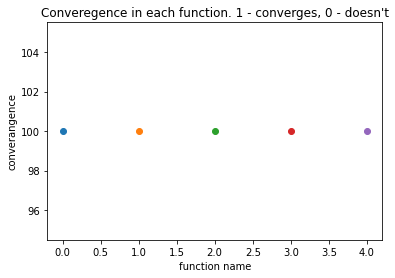

In [383]:
def print_convergence(points, batch):
    for i in range(0, len(name_function)):
        res = call_func(points, batch, gd = name_function[i])
        if (res < EPOCH_MAX) :
            plt.scatter(i,res)
        else :
            plt.scatter(i,res)         
    plt.xlabel("function name")
    plt.ylabel("converangence")
    plt.title("Converegence in each function. 1 - converges, 0 - doesn't")
    plt.show()  

print_convergence(input_3d, 20)      

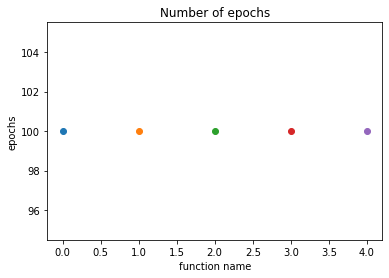

In [384]:
def print_epoch(points, batch):
    for i in range(0, len(name_function)):
        res = call_func(points, batch, gd = name_function[i])
        plt.scatter(i,res)
    plt.xlabel("function name")
    plt.ylabel("epochs")
    plt.title("Number of epochs")
    plt.show()  

print_epoch(input_3d, 10)